In [1]:
from langchain import document_loaders as dl
from langchain import embeddings
from langchain import text_splitter as ts
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_core.tools import tool
import torch
import faiss
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
from IPython.display import Image, display
import os
from langchain import hub
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
import json
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
doc_path = 'C:/Users/Carlini/Desktop/Gianluca/scalfari-2021-ms-can-be-considered-a-primary-progressive-disease-in-all-cases-but-some-patients-have-superimposed.pdf'
loader = dl.PyPDFLoader(doc_path)

doc = loader.load()
text_splitter = ts.RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

all_splits = text_splitter.split_documents(doc)

In [3]:
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

index = faiss.IndexFlatL2(len(embeddings.embed_query("Hello world!")))

vector_store = FAISS(embedding_function=embeddings, index=index, docstore=InMemoryDocstore(), index_to_docstore_id={})

_ = vector_store.add_documents(all_splits)

In [4]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information from documents based on a query"""
    retrieved_docs = vector_store.similarity_search(query, k=6)
    serialized_docs = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )

    return serialized_docs, retrieved_docs

tools = [retrieve]

In [5]:
memory = MemorySaver()

In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_question: str

In [7]:
def grade_documents(state) -> Literal["generate_rag", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the user query.

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    decision: A string indicating the decision
    """

    class grade(BaseModel):
        """
        Binary score for relevance of the retrieved documents
        """

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    model_with_tool = model.with_structured_output(grade)

    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    chain = prompt | model_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate_rag"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state.
    Given the question, it will decide to retrieve using the retriever tool, or simply end.

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    dict: The updated state with the agent response appended to messages
    """

    print("---AGENT INVOKED---")

    template = """
    You are an AI assistant that can help answer questions.
    Given the user question, decide whether to retrieve documents or simply generate an answer.
    Here is the user question: {question}
    Return a JSON with single key 'decision', that is either 'generate' or 'retrieve', depending on the question.
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
    )

    messages = state["messages"]
    user_question = messages[-1].content
    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0, format="json")
    
    chain = prompt | model

    response = chain.invoke(user_question)

    decision = json.loads(response.content)["decision"]

    if decision == "generate":
        print("---DECISION: GENERATE---")
        return "generate"
    elif decision == "retrieve":
        print("---DECISION: RETRIEVE---")
        return "retrieve"


def rewrite(state):
    """
    Transform the query to produce a better question.

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    dict: The updated state with the transformed question appended to messages
    """

    print("---REWRITE INVOKED---")

    messages = state["messages"]
    question = state["user_question"]

    msg = [
        HumanMessage(
            content=f"""\n
        Look at the input and try to reason about the undelying semantic intent / meaning. \n
        Here is the initial question: 
        \n ----------------- \n 
        {question} 
        \n ----------------- \n
        Formulate an improved question. Generate the new question only,
        not your reasoning.
        New question: """,
        )
    ]

    model = ChatOllama(model="llama3.2:3b-instruct-fp16")
    response = model.invoke(msg)

    return {"messages": [response]}

def generate(state):
    """
    Generate an answer without retrieving documents.
    """

    print("---GENERATE INVOKED---")

    messages = state["messages"]
    # question = state["user_question"]

    model = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    response = model.invoke(messages)

    return {"messages": [response]}

def generate_rag(state):
    """
    Generate answer

    Parameters
    ----------
    state (messages): The current state

    Returns
    -------
    dict: The updated state with the generated answer appended to messages
    """

    print("---GENERATE RAG INVOKED---")

    messages = state["messages"]
    question = state["user_question"]
    last_message = messages[-1]

    docs = last_message.content

    prompt = hub.pull("rlm/rag-prompt")

    llm = ChatOllama(model="llama3.2:3b-instruct-fp16", temperature=0)

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    rag_chain = prompt | llm | StrOutputParser()

    response = rag_chain.invoke({"question": question, "context": docs})

    return {"messages": [response]}

In [14]:
workflow = StateGraph(AgentState)

# workflow.add_node("agent", agent)
retrieve_node = ToolNode([retrieve])
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("rewrite", rewrite)
workflow.add_node("generate_rag", generate_rag)
workflow.add_node("generate", generate)
# workflow.add_edge(START, "agent")

workflow.set_conditional_entry_point(
    agent,
    {
        "retrieve": "retrieve",
        "generate": "generate",
    }
)

workflow.add_conditional_edges(
    "retrieve",
    grade_documents,)

workflow.add_edge("generate", END)
workflow.add_edge("generate_rag", END)
workflow.add_edge("rewrite", "retrieve")

graph = workflow.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

In [16]:
import pprint

inputs = {
    "messages": [
        ("user", "Hi llama. how are you?"),
    ]
}
for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---AGENT INVOKED---
---DECISION: GENERATE---
---GENERATE INVOKED---
"Output from node 'generate':"
'---'
{ 'messages': [ AIMessage(content="Déjà vu! You're asking me the same question again! I've already responded that I don't have feelings or emotions, but I'm happy to keep chatting with you! Would you like to talk about something specific or just have a fun conversation?", additional_kwargs={}, response_metadata={'model': 'llama3.2:3b-instruct-fp16', 'created_at': '2024-12-04T15:31:18.644228Z', 'done': True, 'done_reason': 'stop', 'total_duration': 682198700, 'load_duration': 14660100, 'prompt_eval_count': 104, 'prompt_eval_duration': 16000000, 'eval_count': 52, 'eval_duration': 650000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-3414d4dc-c917-4cbd-9827-2fb726a3dedd-0', usage_metadata={'input_tokens': 104, 'output_tokens': 52, 'total_tokens': 156})]}
'\n---\n'


In [13]:
out = graph.invoke(inputs, config=config)


---AGENT INVOKED---
---DECISION: DOCS NOT RELEVANT---
---REWRITE INVOKED---
---AGENT INVOKED---


In [15]:
out["messages"][-1].pretty_print()

================================== Ai Message ==================================

 

Multiple sclerosis (MS) is a chronic autoimmune disease that affects the central nervous system (CNS), which includes the brain, spinal cord, and optic nerves. The symptoms of MS can vary widely from person to person, but common symptoms include:

* Vision problems, such as blurred vision, double vision, or loss of vision
* Muscle weakness, numbness, or tingling in the arms or legs
* Balance and coordination problems
* Difficulty with speech, swallowing, or bladder control
* Fatigue, depression, or anxiety

The exact cause of MS is not known, but it is believed to be an autoimmune disease, where the immune system mistakenly attacks healthy tissue in the CNS. This can lead to damage to the myelin sheath, which surrounds and protects nerve fibers.

Diagnosing MS typically involves a combination of physical exams, medical history, laboratory tests, and imaging studies. The following are some common diagno

In [ ]:
inputs = {
    "messages": [
        ("user", "Which was the first question?"),
    ]
}

for output in graph.stream(inputs, config=config):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

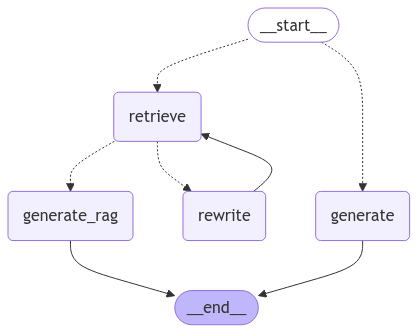

In [15]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
memory = MemorySaver()

state_msg = SystemMessage("You are a chatbot which can retrieve information from documents based on a query.\n"
                          "You should always think about what to do. Do not use any tool if you think it is not necessary.\n")

model = ChatOllama(model="llama3.2:latest")

agent_executor = create_react_agent(model, [retrieve], checkpointer=memory, state_modifier=state_msg)

In [ ]:
config = {"configurable": {"thread_id": "def234"}}
agent_executor.get_state(config=config)

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 'def234'}}, metadata=None, created_at=None, parent_config=None, tasks=())

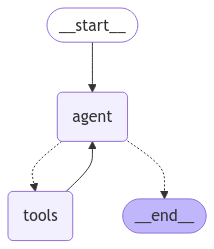

In [ ]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What's your name?"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What's your name?
================================== Ai Message ==================================
Tool Calls:
  retrieve (15c82e66-a4a7-4758-83fa-a316814f1070)
 Call ID: 15c82e66-a4a7-4758-83fa-a316814f1070
  Args:
    query: What is the chatbot's name?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'C:/Users/Carlini/Desktop/Gianluca/scalfari-2021-ms-can-be-considered-a-primary-progressive-disease-in-all-cases-but-some-patients-have-superimposed.pdf', 'page': 1}
Content: comitant epiphenomenon to the primary neuroaxonal 
loss, which potentially promotes the release of highly 
antigenic myelin fragments, secondarily triggering 
the innate and adaptive immune responses. This 
inside-out model would contrast with the traditional 
outside-in view of a primary process, starting in the 
periphery with a dysregulated immune reaction and 
causi

In [ ]:
# config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "Why some scientists do believe that there is no such thing as relapsing-remitting MS? \n"
    "Once you answered, would you show me the parts of the document that support your answer?"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Why some scientists do believe that there is no such thing as relapsing-remitting MS? 
Once you answered, would you show me the parts of the document that support your answer?
================================== Ai Message ==================================
Tool Calls:
  retrieve (dbc240a3-95c1-40db-84e5-5f282d3d4120)
 Call ID: dbc240a3-95c1-40db-84e5-5f282d3d4120
  Args:
    query: Why some scientists do believe that there is no such thing as relapsing-remitting MS?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'C:/Users/Carlini/Desktop/Gianluca/scalfari-2021-ms-can-be-considered-a-primary-progressive-disease-in-all-cases-but-some-patients-have-superimposed.pdf', 'page': 2}
Content: The reasons for the progressive axonal loss are not 
fully known but likely to be multifactorial.
We contend that not all multiple sclerosis (MS) is pro-
gr